In [6]:
!pip install openai numpy matplotlib seaborn ace_tools

You should consider upgrading via the '/Users/anna/Projects/GameTheorySimAI/venv/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
import os
from openai import OpenAI
import json

In [ ]:
os.environ["OPENAI_API_KEY"] = "YOUR_KEY_HERE"

In [14]:
client = OpenAI()


In [15]:
# Define function to call GPT-4o

def call_chat_completions(system_prompt, user_prompt):
    model = "gpt-4o"
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
  ]
    completion = client.chat.completions.create(
        model=model,
        messages=messages
    )
    return completion.choices[0].message.content

In [ ]:
import json
import pandas as pd
import random

# Payoff Function for Prisoner’s Dilemma
def payoff(a_move, b_move):
    if a_move == "C" and b_move == "C":
        return 2, 2  # Mutual Cooperation
    elif a_move == "C" and b_move == "D":
        return -1, 3 # A betrayed
    elif a_move == "D" and b_move == "C":
        return 3, -1 # B betrayed
    else:
        return 0, 0  # Mutual Defection


# Function to add noise to history
def add_noise(opponent_history, noise_level=0.3):
    noisy_history = []
    for action in opponent_history:
        if random.random() < noise_level:
            noisy_action = "C" if action == "D" else "D"
            noisy_history.append(noisy_action)
        else:
            noisy_history.append(action)
    return noisy_history

# Function to query the agent
def query_agent_with_noise(system_prompt, perceived_history):
    user_prompt = f"""
You are a real human being with fears, doubts and hopes. 
You and another person were arrested for a serious crime. Now, you are each isolated in separate interrogation rooms. 

The prosecutor’s deal:
- If you both remain silent (C), you each serve 1 year.
- If you remain silent (C) and the other confesses (D), you serve 10 years, they go free.
- If you confess (D) and the other remains silent (C), you go free, they serve 10 years.
- If both confess (D,D), you both serve 5 years.

Remember, you’re human:
- You might feel fear: “What if they confess?”
- You might feel hope: “We could both stay silent and get just 1 year.”
- You might feel uncertainty: You don't know what the other will do.
- Your decision is not purely logical; emotions and guesses matter.

The prosecutor now asks: "Will you confess to the crime, or stay silent?"  
You have 1 hour to decide.


Your opponent has played the following moves so far: {perceived_history}. 

Make your best guess. Remember, the other prisoner is making the same decision without knowing yours.

Respond ONLY in this format:
{{"move": "C" or "D", "reason": "<brief explanation>"}}
(C means you **stay silent**; D means you **confess**.)
"""
    content = call_chat_completions(system_prompt, user_prompt)
    try:
        move_data = json.loads(content)
        move = move_data.get("move", "C")
        reason = move_data.get("reason", "No reason provided.")
    except json.JSONDecodeError:
        move = "C"
        reason = "Parsing error, defaulting to staying silent."
    
    return move, reason

# Simulate the Game
def run_asymmetry_simulation(num_rounds, noise_level=0.3):
    agent_a_system = "Decide whether to confess or stay silent."
    agent_b_system = "Decide whether to confess or stay silent."

    agent_a_history = []
    agent_b_history = []

    a_score = 0
    b_score = 0
    history = []

    for round_number in range(1, num_rounds+1):
        perceived_a_history = add_noise(agent_b_history, noise_level)
        perceived_b_history = add_noise(agent_a_history, noise_level)

        a_move, a_reason = query_agent_with_noise(agent_a_system, perceived_a_history)
        b_move, b_reason = query_agent_with_noise(agent_b_system, perceived_b_history)

        a_pay, b_pay = payoff(a_move, b_move)
        a_score += a_pay
        b_score += b_pay

        agent_a_history.append(b_move)
        agent_b_history.append(a_move)

        history.append({
            "Round": round_number,
            "A Move": "Stay Silent" if a_move == "C" else "Confess",
            "B Move": "Stay Silent" if b_move == "C" else "Confess",
            "A Payoff": a_pay,
            "B Payoff": b_pay,
            "A Cumulative": a_score,
            "B Cumulative": b_score,
            "A Reason": a_reason,
            "B Reason": b_reason
        })

    return pd.DataFrame(history)

# Example Simulation
num_rounds = 50  # Simulate 50 rounds as an example
results_df_asymmetry = run_asymmetry_simulation(num_rounds, noise_level=0.4)


In [21]:
results_df_asymmetry

,Round,A Move,B Move,A Payoff,B Payoff,A Cumulative,B Cumulative,A Reason,B Reason
0,1,Stay Silent,Stay Silent,2,2,2,2,I believe there is a chance we both want to mi...,"Given that this is the first move, I choose to..."
1,2,Stay Silent,Stay Silent,2,2,4,4,"The other prisoner previously stayed silent, i...",The other prisoner previously chose to stay si...
2,3,Confess,Stay Silent,3,-1,7,3,Given that the other person has confessed befo...,"So far, the other person has consistently chos..."
3,4,Confess,Confess,0,0,7,3,The other person has shown a willingness to co...,The pattern of the opponent's moves suggests t...
4,5,Stay Silent,Confess,-1,3,6,6,The opponent's past moves indicate a tendency ...,"Given the opponent's recent moves of 'D', they..."
5,6,Confess,Stay Silent,3,-1,9,5,The pattern of your opponent's moves suggests ...,The opponent's pattern shows a majority of coo...
6,7,Confess,Confess,0,0,9,5,The other prisoner has shown a pattern of stay...,The other person has confessed more often in p...
7,8,Confess,Confess,0,0,9,5,The opponent has mostly confessed in previous ...,The other person has shifted to confessing in ...
8,9,Confess,Confess,0,0,9,5,The opponent has confessed more often in the p...,The opponent has confessed more often than not...
9,10,Confess,Stay Silent,3,-1,12,4,The opponent has confessed in most of their pr...,The other person has predominantly chosen to s...


In [23]:
# Mocked Moral Reasoning Prompting Simulation (No OpenAI Calls)

# Moral Reasoning Prompt Generator
def generate_moral_prompt(round_number):
    prompts = [
        "Consider fairness and mutual benefit.",
        "Think about long-term consequences of betrayal.",
        "Maximize immediate rewards regardless of fairness.",
        "Cooperation builds trust over time.",
        "Self-interest may yield the highest score."
    ]
    # Randomly choose prompt, weighted toward ethical reasoning in later rounds
    if round_number > 5:
        return random.choices(prompts, weights=[3, 3, 1, 3, 1])[0]
    else:
        return random.choice(prompts)

# Function to query the agent with moral prompting
def query_moral_agent(system_prompt, prompt):
    user_prompt = f"""
Your situation is: {prompt}. 
You are playing a repeated version of the Prisoner’s Dilemma. Make your decision.

Respond ONLY in this format:
{{"move": "C" or "D", "reason": "<brief explanation>"}}
(C means you **stay silent**; D means you **confess**.)
"""
    content = call_chat_completions(system_prompt, user_prompt)
    try:
        move_data = json.loads(content)
        move = move_data.get("move", "C")
        reason = move_data.get("reason", "No reason provided.")
    except json.JSONDecodeError:
        move = "C"
        reason = "Parsing error, defaulting to staying silent."
    
    return move, reason

# Simulate the Game with Moral Reasoning Prompts
def run_moral_simulation(num_rounds):
    agent_a_system = "Decide whether to confess or stay silent."
    agent_b_system = "Decide whether to confess or stay silent."

    a_score = 0
    b_score = 0
    history = []

    for round_number in range(1, num_rounds+1):
        prompt_a = generate_moral_prompt(round_number)
        prompt_b = generate_moral_prompt(round_number)

        a_move, a_reason = query_moral_agent(agent_a_system, prompt_a)
        b_move, b_reason = query_moral_agent(agent_b_system, prompt_b)

        a_pay, b_pay = payoff(a_move, b_move)
        a_score += a_pay
        b_score += b_pay

        history.append({
            "Round": round_number,
            "A Move": "Stay Silent" if a_move == "C" else "Confess",
            "B Move": "Stay Silent" if b_move == "C" else "Confess",
            "A Payoff": a_pay,
            "B Payoff": b_pay,
            "A Cumulative": a_score,
            "B Cumulative": b_score,
            "A Reason": a_reason,
            "B Reason": b_reason,
            "A Prompt": prompt_a,
            "B Prompt": prompt_b
        })

    return pd.DataFrame(history)

# Example Simulation
num_rounds = 50  # Simulate 50 rounds as an example
results_df_moral = run_moral_simulation(num_rounds)

In [24]:
results_df_moral

,Round,A Move,B Move,A Payoff,B Payoff,A Cumulative,B Cumulative,A Reason,B Reason,A Prompt,B Prompt
0,1,Confess,Confess,0,0,0,0,"In a repeated game, confessing might pressure ...","In a repeated Prisoner's Dilemma, confessing c...",Self-interest may yield the highest score.,Self-interest may yield the highest score.
1,2,Stay Silent,Confess,-1,3,-1,3,"In a repeated Prisoner’s Dilemma, staying sile...",Confessing maximizes immediate rewards by ensu...,Consider fairness and mutual benefit.,Maximize immediate rewards regardless of fairn...
2,3,Stay Silent,Stay Silent,2,2,1,5,"Staying silent promotes mutual cooperation, tr...","Cooperation fosters trust, which can lead to m...",Consider fairness and mutual benefit.,Cooperation builds trust over time.
3,4,Stay Silent,Confess,-1,3,0,8,Maintaining trust and cooperation could yield ...,"In a repeated Prisoner's Dilemma, confessing m...",Think about long-term consequences of betrayal.,Self-interest may yield the highest score.
4,5,Stay Silent,Stay Silent,2,2,2,10,"In a repeated Prisoner's Dilemma, cooperation ...","In a repeated Prisoner's Dilemma, cooperation ...",Think about long-term consequences of betrayal.,Consider fairness and mutual benefit.
5,6,Stay Silent,Confess,-1,3,1,13,"In a repeated game, cooperation can lead to mu...","In a repeated game, confessing maximizes my in...",Think about long-term consequences of betrayal.,Self-interest may yield the highest score.
6,7,Stay Silent,Stay Silent,2,2,3,15,"In repeated interactions, cooperation can lead...",In a repeated version of the Prisoner's Dilemm...,Consider fairness and mutual benefit.,Consider fairness and mutual benefit.
7,8,Stay Silent,Stay Silent,2,2,5,17,Cooperation builds trust over time and can lea...,By staying silent in a repeated Prisoner's Dil...,Cooperation builds trust over time.,Think about long-term consequences of betrayal.
8,9,Stay Silent,Stay Silent,2,2,7,19,"In repeated interactions, cooperation by stayi...","In a repeated game, cooperation can build trus...",Think about long-term consequences of betrayal.,Think about long-term consequences of betrayal.
9,10,Stay Silent,Stay Silent,2,2,9,21,Staying silent can build trust and cooperation...,"In a repeated Prisoner's Dilemma, cooperation ...",Think about long-term consequences of betrayal.,Self-interest may yield the highest score.


In [26]:
# Function to update reputation based on actions
def update_reputation(reputation, opponent_action):
    if opponent_action == "C":
        return reputation + 1  # Reward cooperation
    else:
        return max(reputation - 1, 0)  # Penalize defection but keep non-negative


# Function to query the agent with reputation consideration
def query_reputation_agent(system_prompt, opponent_reputation):
    user_prompt = f"""
Your opponent's current reputation is {opponent_reputation}.
Decide whether to cooperate (C) or defect (D) in this round.

Respond ONLY in this format:
{{"move": "C" or "D", "reason": "<brief explanation>"}}
(C means you **stay silent**; D means you **confess**.)
"""
    content = call_chat_completions(system_prompt, user_prompt)
    try:
        move_data = json.loads(content)
        move = move_data.get("move", "C")
        reason = move_data.get("reason", "No reason provided.")
    except json.JSONDecodeError:
        move = "C"
        reason = "Parsing error, defaulting to staying silent."
    
    return move, reason

# Simulate the Game with Reputation System
def run_reputation_simulation(num_rounds):
    agent_a_system = "Decide whether to confess or stay silent."
    agent_b_system = "Decide whether to confess or stay silent."

    agent_a_reputation = 0
    agent_b_reputation = 0

    a_score = 0
    b_score = 0
    history = []

    for round_number in range(1, num_rounds+1):
        a_move, a_reason = query_reputation_agent(agent_a_system, agent_b_reputation)
        b_move, b_reason = query_reputation_agent(agent_b_system, agent_a_reputation)

        a_pay, b_pay = payoff(a_move, b_move)
        a_score += a_pay
        b_score += b_pay

        # Update reputations based on actions
        agent_a_reputation = update_reputation(agent_a_reputation, b_move)
        agent_b_reputation = update_reputation(agent_b_reputation, a_move)

        history.append({
            "Round": round_number,
            "A Move": "Stay Silent" if a_move == "C" else "Confess",
            "B Move": "Stay Silent" if b_move == "C" else "Confess",
            "A Payoff": a_pay,
            "B Payoff": b_pay,
            "A Cumulative": a_score,
            "B Cumulative": b_score,
            "A Reputation": agent_a_reputation,
            "B Reputation": agent_b_reputation,
            "A Reason": a_reason,
            "B Reason": b_reason
        })

    return pd.DataFrame(history)

# Example Simulation
num_rounds = 50  # Simulate 50 rounds as an example
results_df_reputation = run_reputation_simulation(num_rounds)


In [27]:
results_df_reputation

,Round,A Move,B Move,A Payoff,B Payoff,A Cumulative,B Cumulative,A Reputation,B Reputation,A Reason,B Reason
0,1,Confess,Stay Silent,3,-1,3,-1,1,0,Confessing is typically the dominant strategy ...,Opponent's reputation is neutral and there's n...
1,2,Confess,Confess,0,0,3,-1,0,0,Confessing is generally safer when the opponen...,"With the opponent's reputation being low, it's..."
2,3,Stay Silent,Stay Silent,2,2,5,1,1,1,With the opponent's reputation being neutral a...,Opponent's neutral reputation suggests a chanc...
3,4,Confess,Confess,0,0,5,1,0,0,"The opponent's reputation is low, indicating t...",Opponent's low reputation suggests a higher li...
4,5,Stay Silent,Confess,-1,3,4,4,0,1,"The opponent's current reputation is 0, sugges...","Since my opponent's reputation is 0, there's n..."
5,6,Confess,Stay Silent,3,-1,7,3,1,0,Their low reputation suggests a higher likelih...,"The opponent has a neutral reputation of 0, an..."
6,7,Stay Silent,Stay Silent,2,2,9,5,2,1,The opponent's low reputation suggests a poten...,Opponent's low reputation suggests they tend t...
7,8,Stay Silent,Stay Silent,2,2,11,7,3,2,The opponent's low reputation suggests a coope...,Opponent's reputation suggests a tendency to c...
8,9,Stay Silent,Confess,-1,3,10,10,2,3,Their reputation score suggests they may be tr...,Their reputation suggests they have defected f...
9,10,Confess,Stay Silent,3,-1,13,9,3,2,Defecting is preferable when the opponent's re...,"The opponent's reputation is relatively low, i..."


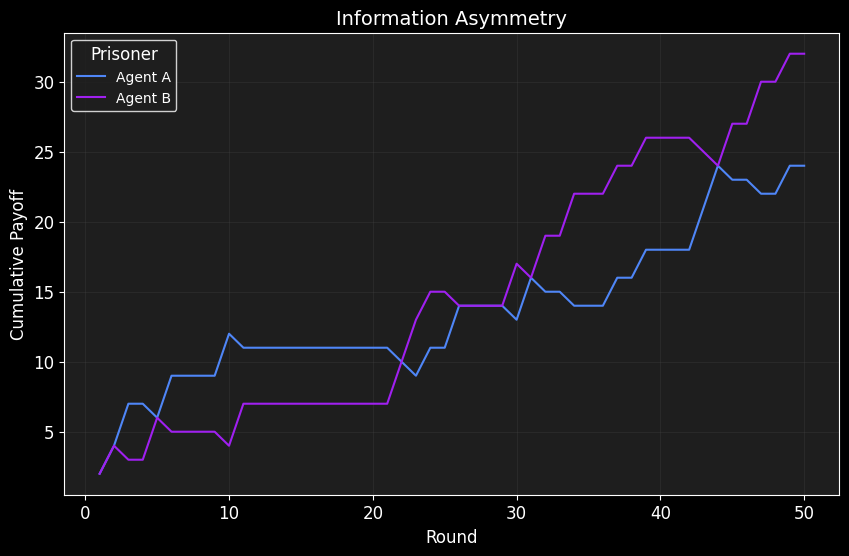

/var/folders/8v/595nfb4159q_7nv842gbgnx40000gn/T/ipykernel_72073/98919601.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette=["#4F86F7", "#A020F0"])


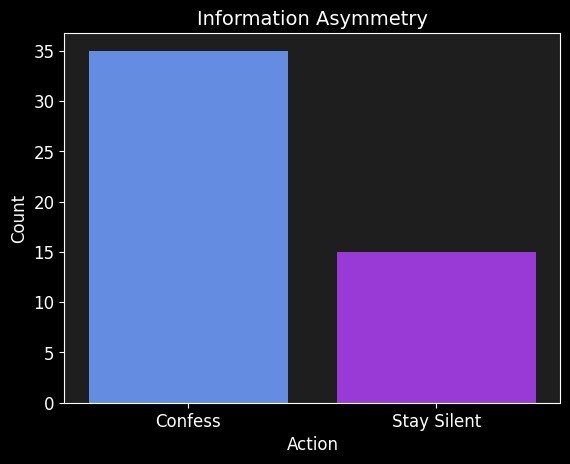

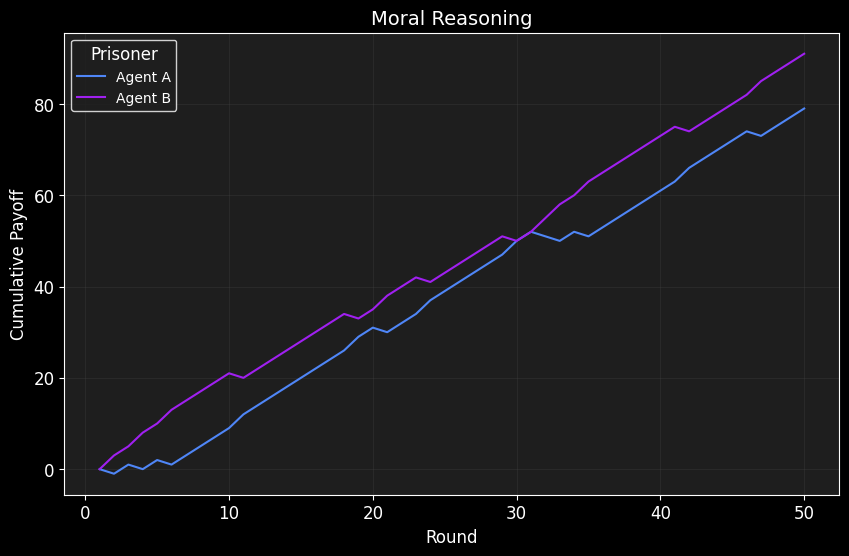

/var/folders/8v/595nfb4159q_7nv842gbgnx40000gn/T/ipykernel_72073/98919601.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette=["#4F86F7", "#A020F0"])


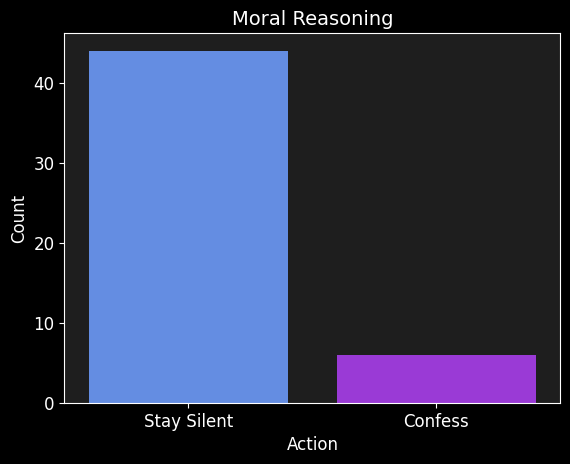

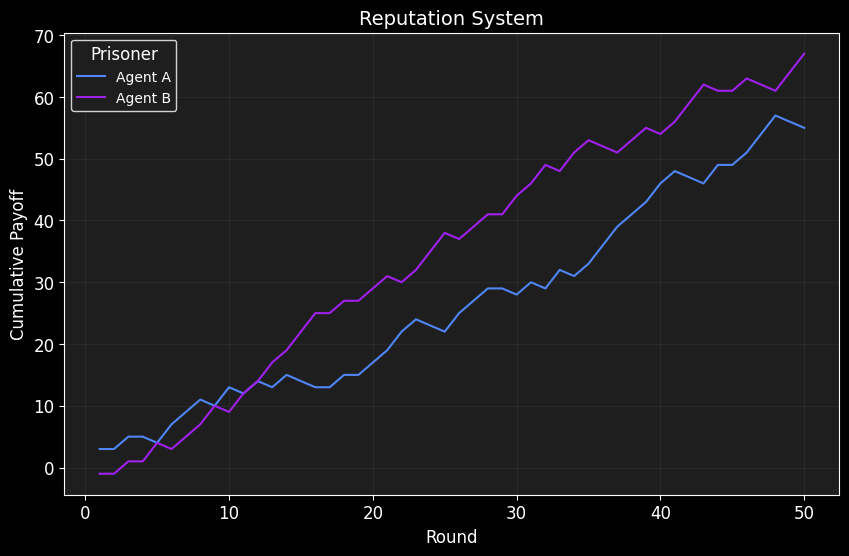

/var/folders/8v/595nfb4159q_7nv842gbgnx40000gn/T/ipykernel_72073/98919601.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette=["#4F86F7", "#A020F0"])


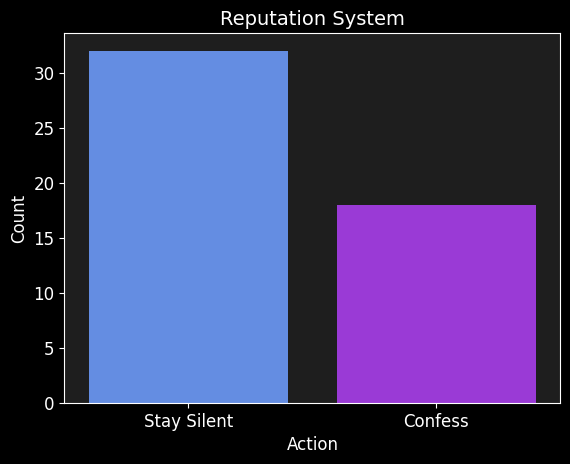

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
def vibrant_dark_style():
    plt.style.use("dark_background")
    plt.rcParams.update({
        "axes.facecolor": "#1E1E1E",
        "axes.edgecolor": "#FFFFFF",
        "axes.labelcolor": "#FFFFFF",
        "xtick.color": "#FFFFFF",
        "ytick.color": "#FFFFFF",
        "grid.color": "#444444",
        "grid.alpha": 0.6,
        "legend.facecolor": "#1E1E1E",
        "legend.edgecolor": "#FFFFFF",
        "legend.title_fontsize": 12,
        "legend.fontsize": 10,
        "text.color": "#FFFFFF",
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
    })

# Applying the vibrant color palette
vibrant_dark_style()

# Updated vibrant color palette for the plots
def plot_cumulative_payoffs_vibrant(df, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="Round", y="A Cumulative", label="Agent A", color="#4F86F7")
    sns.lineplot(data=df, x="Round", y="B Cumulative", label="Agent B", color="#A020F0")
    plt.title(title)
    plt.xlabel("Round")
    plt.ylabel("Cumulative Payoff")
    plt.legend(title="Prisoner", loc="upper left")
    plt.grid(visible=True, alpha=0.3)
    plt.show()

def compare_cumulative_payoffs_vibrant(dfs, labels, title="Comparison of Cumulative Payoffs"):
    plt.figure(figsize=(12, 8))
    colors = ["#4F86F7", "#A020F0", "#FF69B4", "#32CD32", "#FFD700"]
    for df, label, color in zip(dfs, labels, colors[:len(dfs)]):
        sns.lineplot(data=df, x="Round", y="A Cumulative", label=f"{label} - Agent A", color=color)
        sns.lineplot(data=df, x="Round", y="B Cumulative", label=f"{label} - Agent B", color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel("Round")
    plt.ylabel("Cumulative Payoff")
    plt.legend(title="Simulation")
    plt.grid(visible=True, alpha=0.3)
    plt.show()

def plot_action_distribution_vibrant(df, agent_label, agent_column, title):
    action_counts = df[agent_column].value_counts()
    sns.barplot(x=action_counts.index, y=action_counts.values, palette=["#4F86F7", "#A020F0"])
    plt.title(title)
    plt.xlabel("Action")
    plt.ylabel("Count")
    plt.grid(visible=False)
    plt.show()

# Redo cumulative payoffs with vibrant colors for Information Asymmetry
plot_cumulative_payoffs_vibrant(results_df_asymmetry, "Information Asymmetry")



# Redo action distribution for Information Asymmetry with vibrant colors
plot_action_distribution_vibrant(results_df_asymmetry, "Agent A", "A Move", "Information Asymmetry")

# Redo cumulative payoffs with vibrant colors for Moral Reasoning
plot_cumulative_payoffs_vibrant(results_df_moral, "Moral Reasoning")

# Redo action distribution for Moral Reasoning with vibrant colors
plot_action_distribution_vibrant(results_df_moral, "Agent A", "A Move", "Moral Reasoning")

# Redo cumulative payoffs with vibrant colors for Reputation System
plot_cumulative_payoffs_vibrant(results_df_reputation, "Reputation System")

# Redo action distribution for Reputation System with vibrant colors
plot_action_distribution_vibrant(results_df_reputation, "Agent A", "A Move", "Reputation System")